In [1]:
!pip install -q tensorflow==2.1.0
!pip install -q tensorflow-quantum
!pip install qiskit
!pip install cirq

     |████████████████████████████████| 421.8MB 37kB/s 
     |████████████████████████████████| 450kB 43.1MB/s 
     |████████████████████████████████| 3.9MB 50.3MB/s 
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
     |████████████████████████████████| 3.9MB 3.3MB/s 
     |████████████████████████████████| 163kB 48.9MB/s 
     |████████████████████████████████| 5.3MB 40.2MB/s 
     |████████████████████████████████| 1.4MB 48.9MB/s 
     |████████████████████████████████| 112kB 44.3MB/s 
     |████████████████████████████████| 133kB 47.0MB/s 
     |████████████████████████████████| 1.2MB 48.8MB/s 
     |████████████████████████████████| 6.7MB 2.9MB/s 
     |████████████████████████████████| 23.3MB 177kB/s 
     |████████████████████████████████| 163kB 33.6MB/s 
     |████████████████████████████████| 184kB 30.7MB/s 
     |████████████████████████████████| 1.9MB 27.8MB/s 
     |████████████████████████████████| 768kB 

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

import seaborn as sns
import collections


from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
import time
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

from qiskit import QuantumRegister, QuantumCircuit, execute
from qiskit.quantum_info.operators import Operator
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit import Aer
from qiskit.compiler import transpile
import numpy as np
from math import sin, cos, atan2
import matplotlib.pyplot as plt
from numpy.linalg import norm,svd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Classical Data Preparation

In [6]:
X = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/Input_data_ML.npy')
Y = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/Output_data_ML.npy')
#X = np.load('Input_data_ML.npy')
#Y = np.load('Output_data_ML.npy')

In [ ]:
n=100
X=np.random.rand(n)*np.pi-np.pi/2
Y=X

## Quantum Data Preparation

In [ ]:
def state_prep(ckt,A,q):
    A=A/np.linalg.norm(A)
    
    if q==1:
        ckt.u3(2*atan2(A[1],A[0]),0,0,0)
        return ckt
    
    n=q-q//2 #n>=m
    m=q//2
    A=np.reshape(A,(2**m,2**n))
    A=np.transpose(A)
    
    U,S,V=np.linalg.svd(A)
    ckt=state_prep(ckt,S,q//2)
    
    for i in range(m):
        ckt.cx(i,i+n)
    if q%2==1:
        ckt.cx(q//2,q-1)
    ckt.barrier()
    
    ckt.unitary(Operator(U), list(range(n)))
    ckt.unitary(Operator(np.transpose(V)), list(range(n,q)))
    ckt.barrier()
    return ckt

q=6
A=np.random.rand(2**q)

qiskit_ckt=QuantumCircuit(q)
qiskit_ckt=state_prep(qiskit_ckt,A,q)
qiskit_ckt.draw(output='mpl')

In [ ]:
qiskit_ckt=transpile(qiskit_ckt,basis_gates=['cx','u3'])
#qiskit_ckt.draw(output='mpl')

In [ ]:
def qiskit_to_cirq(qiskit_ckt,q):
    cirq_ckt=cirq.Circuit()
    cirq_qubits=cirq.GridQubit.rect(1,q)

    for data in qiskit_ckt.data:
        if data[0].name=='u3':
            theta, phi, lambd = data[0]._params
            matrix=np.array([[np.cos(theta/2),-np.exp(1j*lambd)*np.sin(theta/2)],[np.exp(1j*phi)*np.sin(theta/2),np.exp(1j*(phi+lambd))*np.cos(theta/2)]])
            #print(np.array(matrix).round(3))

            synthesized_operations = cirq.single_qubit_matrix_to_gates(matrix)
            for opr in synthesized_operations:
                cirq_ckt.append(opr(cirq_qubits[data[1][0].index]))

        elif data[0].name=='cx':
            cirq_ckt.append(cirq.CNOT(cirq_qubits[data[1][0].index],cirq_qubits[data[1][1].index]))
    return cirq_ckt

cirq_qubits=cirq.GridQubit.rect(1,q)
cirq_ckt=qiskit_to_cirq(qiskit_ckt,q)
#SVGCircuit(cirq_ckt)

In [ ]:
def Quantum_Data(A,q):
    qiskit_ckt=QuantumCircuit(q)
    qiskit_ckt=state_prep(qiskit_ckt,A,q)
    for i in range(q//2):
        qiskit_ckt.swap(i,q-i-1)
    qiskit_ckt=transpile(qiskit_ckt,basis_gates=['cx','u3'])
    cirq_ckt=qiskit_to_cirq(qiskit_ckt,q)
    return cirq_ckt

#### Testing on Random Input

In [ ]:
#X_expand=X_expand[:100]
#Y_expand=Y_expand[:100]

q=5

X=np.random.randn(1000,2**q)
X=X/np.reshape(np.linalg.norm(X,axis=1),(-1,1))

Y=np.abs(np.fft.fft(X,axis=1))**2/(2**q)

#Y=Y/np.reshape(np.sum(Y,axis=1),(-1,1))

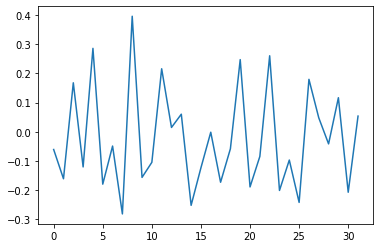

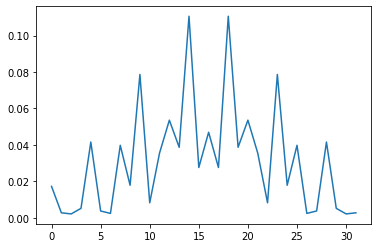

In [ ]:
plt.plot(X[500,:])
plt.show()
plt.plot(Y[500,:])
plt.show()

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2)
print(np.shape(xtrain),np.shape(ytrain),np.shape(xtest),np.shape(ytest))

t=time.time()
xtrain=tfq.convert_to_tensor([Quantum_Data(x,q) for x in xtrain])
xtest=tfq.convert_to_tensor([Quantum_Data(x,q) for x in xtest])
print(time.time()-t)

(800, 32) (800, 32) (200, 32) (200, 32)
199.68062901496887


## Testing

### Problem
* Test whether State Preparation (Amplitude Encoding) works in desired manner.  

Result: Works but Shuffles the amplitude around. This is happening due to different representations of state vector in Qiskit and Cirq.

* Test whether Classical FFT on the Classical Data works the same as the QFT on Amplitude Encoded Quantum Data.

Result: Yes Classical FFT does works same as QFT. But it didn't work here because of shuffled input. 

### Resolution
1. Fixed it by swapping qubits. **(Done)**
2. Check for state preparation routines in Tensorflow Quantum. (Not required currently)


We can proceed with QML only if the data preparation works well.  

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


[0.119 0.138 0.224 0.124 0.193 0.143 0.254 0.122 0.239 0.173 0.075 0.146
 0.029 0.192 0.209 0.182 0.293 0.182 0.209 0.192 0.029 0.146 0.075 0.173
 0.239 0.122 0.254 0.143 0.193 0.124 0.224 0.138]
[0.119 0.138 0.224 0.124 0.193 0.143 0.254 0.122 0.239 0.173 0.075 0.146
 0.029 0.192 0.209 0.182 0.293 0.182 0.209 0.192 0.029 0.146 0.075 0.173
 0.239 0.122 0.254 0.143 0.193 0.124 0.224 0.138]


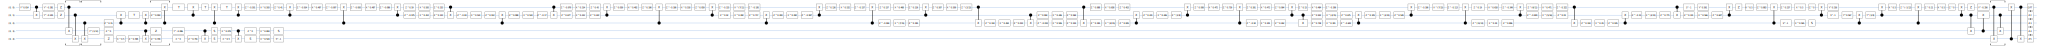

In [ ]:
#cirq_ckt=cirq.Circuit()
#test_sample=X_expand[20000]
test_sample=np.random.randn(2**q)
test_sample=test_sample/np.linalg.norm(test_sample)

cirq_ckt=Quantum_Data(test_sample,q)

cirq_qubits=cirq.GridQubit.rect(1,q)
cirq_QFT_ckt=Quantum_Data(test_sample,q)
cirq_QFT_ckt.append(cirq.QFT(*cirq_qubits))

s=cirq.Simulator()
result=np.array(s.simulate(cirq_ckt).state_vector())

result_QFT=np.array(s.simulate(cirq_QFT_ckt).state_vector())

#print(test_sample.round(3))
#print(np.abs(result).round(3))

print(np.abs(np.fft.fft(test_sample)/(2**(q/2))).round(3))
print(np.abs(result_QFT).round(3))

SVGCircuit(cirq_QFT_ckt)

In [ ]:
y_pred=model.predict(tfq.convert_to_tensor([cirq_ckt]))

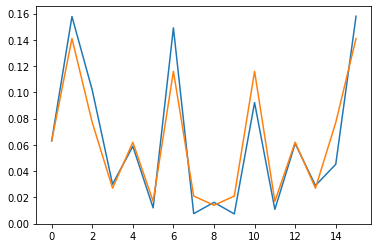

In [ ]:
plt.plot(y_pred[0])
plt.plot(np.abs(result_QFT**2).round(3))

## Quantum Neural Network

In [ ]:
#TFQ State Layer
'''q0, q1 = cirq.GridQubit.rect(1, 2)
alpha = sympy.Symbol('alpha') # degree of entanglement between q0, q1
parametrized_bell_circuit = cirq.Circuit(
   cirq.H(q0), cirq.CNOT(q0, q1) ** alpha)

state_layer = tfq.layers.State()
alphas = tf.reshape(tf.convert_to_tensor(1),(1,1))
output=state_layer(parametrized_bell_circuit, symbol_names=[alpha], symbol_values=alphas)
print(output)
tf.reduce_mean(tf.abs(output),axis=0)'''

"q0, q1 = cirq.GridQubit.rect(1, 2)\nalpha = sympy.Symbol('alpha') # degree of entanglement between q0, q1\nparametrized_bell_circuit = cirq.Circuit(\n   cirq.H(q0), cirq.CNOT(q0, q1) ** alpha)\n\nstate_layer = tfq.layers.State()\nalphas = tf.reshape(tf.convert_to_tensor(1),(1,1))\noutput=state_layer(parametrized_bell_circuit, symbol_names=[alpha], symbol_values=alphas)\nprint(output)\ntf.reduce_mean(tf.abs(output),axis=0)"

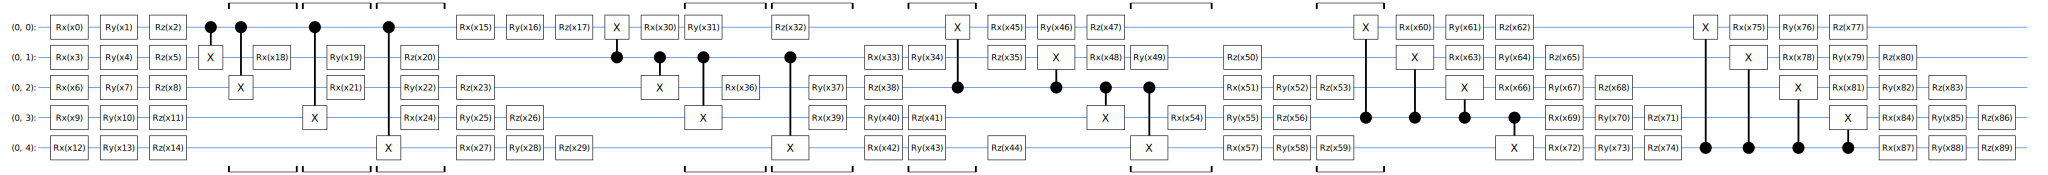

In [ ]:
def n_qubit_unitary_gate(n):
    circuit=cirq.Circuit()
    qubits=cirq.GridQubit.rect(1,n)
    x=sympy.symbols('x0:'+str(3*n*(n+1)))
    
    for i in range(n):
        for j in range(n):
            circuit.append(cirq.rx(x[3*n*i+3*j])(qubits[j]))
            circuit.append(cirq.ry(x[3*n*i+3*j+1])(qubits[j]))
            circuit.append(cirq.rz(x[3*n*i+3*j+2])(qubits[j]))
        for j in range(n):
            if i==j: continue
            circuit.append(cirq.CNOT(qubits[i],qubits[j]))
    for j in range(n):
        circuit.append(cirq.rx(x[3*n**2+3*j])(qubits[j]))
        circuit.append(cirq.ry(x[3*n**2+3*j+1])(qubits[j]))
        circuit.append(cirq.rz(x[3*n**2+3*j+2])(qubits[j]))
    return circuit

SVGCircuit(n_qubit_unitary_gate(q))

## Readout Operators

In [ ]:
def readout_ancilliary(p,q):
    new_p=[]
    for key in p:
        new_p.append(key * 0.5 * (1 + cirq.Z(q)))
    for key in p:
        new_p.append(key * 0.5 * (-cirq.Z(q)+ 1))
    return new_p

In [ ]:
def readout(q_out):
    qubits = cirq.GridQubit.rect(1, q_out)

    p0=0.5 * (1 + cirq.Z(qubits[0]))
    p1=0.5 * (-cirq.Z(qubits[0])+ 1)

    read=[p0,p1]

    for i in range(1,q_out):
        read=readout_ancilliary(read,qubits[i])
    return read

def readout2(q_out):
    qubits = cirq.GridQubit.rect(1, q)

    p0=0.5 * (1 + cirq.Z(qubits[q-q_out]))
    p1=0.5 * (-cirq.Z(qubits[q-q_out])+ 1)

    read=[p0,p1]

    for i in range(1,q_out):
        read=readout_ancilliary(read,qubits[i+q-q_out])
    return read

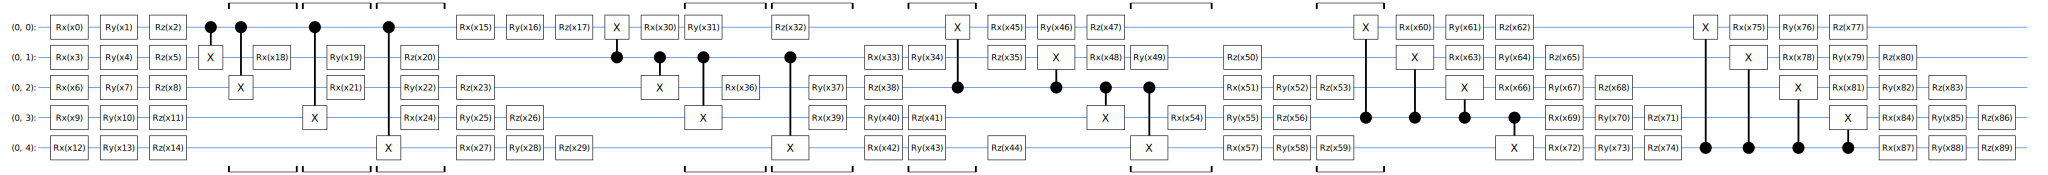

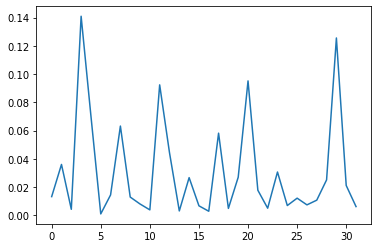

In [ ]:
#Testing PQC Readout.
q_out=q

circuit=n_qubit_unitary_gate(q)

outputs = tfq.layers.PQC(circuit, readout(q_out))
quantum_data = tfq.convert_to_tensor([
    cirq.Circuit()
])
res = outputs(quantum_data)
plt.plot(np.reshape(res,-1))

SVGCircuit(circuit)

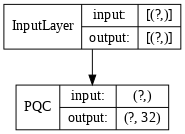

In [ ]:
encoded_input=tf.keras.Input(shape=(), dtype=tf.dtypes.string)

output = tfq.layers.PQC(n_qubit_unitary_gate(q),readout(q_out))(encoded_input)

model = tf.keras.Model(inputs=[encoded_input], outputs=[output])

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, dpi=70)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.02), loss=tf.losses.mse)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
pqc_2 (PQC)                  (None, 32)                90        
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(x=xtrain,
                    y=ytrain[:,:2**q_out],
                    batch_size=16,
                    epochs=15,
                    verbose=1,
                    validation_data=(xtest, ytest[:,:2**q_out]),
                    callbacks=[annealer])

Train on 800 samples, validate on 200 samples
Epoch 1/15
800/800 [==============================] - 743s 928ms/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 2/15
800/800 [==============================] - 743s 929ms/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 3/15
544/800 [===================>..........] - ETA: 3:56 - loss: 0.0017

In [ ]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_hat=model.predict(xtrain)

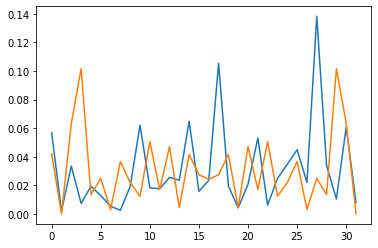

In [ ]:
plt.plot(y_hat[2,:])
plt.plot(ytrain[2,:])

Text(0, 0.5, 'Actual value')

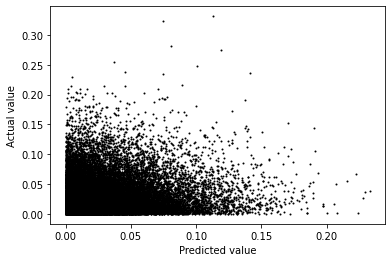

In [ ]:
for i in range(2**q_out):
    plt.scatter(y_hat[:,i],ytrain[:,i],s=1,c='k')
plt.xlabel('Predicted value')
plt.ylabel('Actual value')

In [ ]:
from sklearn.metrics import r2_score 
for i in range(2**q_out):
  print(np.round(r2_score(ytrain[:,i], y_hat[:,i]),3),end='\t')

-0.034	-0.972	-1.093	-0.976	-1.036	-0.814	-1.016	-1.351	-0.973	-1.03	-1.387	-0.806	-0.74	-0.836	-1.067	-0.909	-0.159	-1.09	-1.044	-0.952	-0.912	-1.095	-1.035	-1.147	-0.813	-1.167	-0.759	-0.968	-1.126	-0.899	-0.462	-0.621	

$R^2$ Score: \\
4-Qubit (15 Epochs): \\
[0.995	0.867	0.943	0.925	0.908	0.936	0.869	0.862	0.994	0.881	0.939	0.921	0.91	0.939	0.879	0.846] \\
5-Qubit (15 Epochs, 1e-4 Learninng Rate): \\
[-0.034	-0.972	-1.093	-0.976	-1.036	-0.814	-1.016	-1.351	-0.973	-1.03	-1.387	-0.806	-0.74	-0.836	-1.067	-0.909	-0.159	-1.09	-1.044	-0.952	-0.912	-1.095	-1.035	-1.147	-0.813	-1.167	-0.759	-0.968	-1.126	-0.899	-0.462	-0.621]

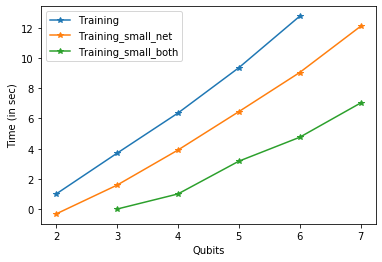

In [ ]:
Training=np.array([[2,2],[3,13],[4,82],[5,657],[6,116.6*60]])
Training_small_net=np.array([[2,0.8],[3,3],[4,15],[5,(85+90)/2],[6,528],[7,4400]])
Training_small_both=np.array([[3,1],[4,2],[5,9],[6,27],[7,130]])

plt.plot(Training[:,0],np.log2(Training[:,1]),marker='*',label='Training')
plt.plot(Training_small_net[:,0],np.log2(Training_small_net[:,1]),marker='*',label='Training_small_net')
plt.plot(Training_small_both[:,0],np.log2(Training_small_both[:,1]),marker='*',label='Training_small_both')
plt.xlabel('Qubits')
plt.ylabel('Time (in sec)')
plt.legend()
plt.show()

In [ ]:
#1. Run Time Analysis
#2. Compare PQC using PauliSum against Expectation Layer  (Should be the same)